<a href="https://colab.research.google.com/github/HsiangHung/Machine_Learning_Note/blob/master/GNN_2_Semi_Supervised_Classification_with_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-supervised Classification with Graph Convolutional Networks (GCN)

**NOTE**: This colab notebook follows Daniel Holmberg's blog: [Graph Neural Networks in Python](https://towardsdatascience.com/graph-neural-networks-in-python-c310c7c18c83)

### Reference

* seminal paper: [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)
* Blog: [Graph Neural Networks in Python](https://towardsdatascience.com/graph-neural-networks-in-python-c310c7c18c83)
* Thomas Kipf's blog: [GRAPH CONVOLUTIONAL NETWORKS](https://tkipf.github.io/graph-convolutional-networks/#footer)


## Basic Graph

In [2]:
import networkx as nx
import numpy as np

In [2]:
H = nx.DiGraph()

In [3]:
H.add_nodes_from([
  (0, {"color": "gray", "size": 450}),
  (1, {"color": "yellow", "size": 700}),
  (2, {"color": "red", "size": 250}),
  (3, {"color": "pink", "size": 500})
])
for node in H.nodes(data=True):
  print(node)

H.add_edges_from([
  (0, 1),
  (1, 2),
  (2, 0),
  (2, 3),
  (3, 2)
])

(0, {'color': 'gray', 'size': 450})
(1, {'color': 'yellow', 'size': 700})
(2, {'color': 'red', 'size': 250})
(3, {'color': 'pink', 'size': 500})


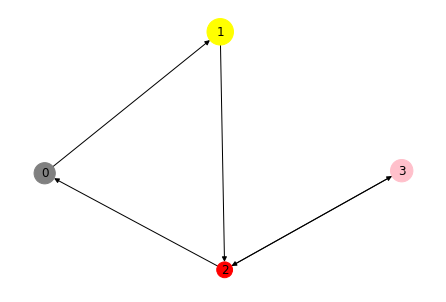

In [4]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)


In [3]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.13.0+cu116


# Install torch-geometric

Note the apple M1 chip does not support running torch-geometric package. When importing it will show the following error message 

      zsh: bus error  python

For more detail, see the blog:
* [Importing SciPy in Python 3.9.1 yields zsh: bus error; Apple Silicon M1 Mac OS 11](https://github.com/scipy/scipy/issues/13416)

In this colab, before importing we need to install the dependence (**this installation process will take a while**):

In [1]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 106 kB 5.7 MB/s 
  Created wheel for torch-scatter: filename=torch_scatter-2.1.0-cp38-cp38-linux_x86_64.whl size=477429 sha256=2dd16dab5f951e64dedaad34b433d41be957ed8db3cfd689d57d175f15c9b8a0
  Stored in directory: /root/.cache/pip/wheels/41/7f/4f/cf072bea3b6efe4561de2db3603ebbd8718c134c24caab8281
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 208 kB 4.8 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.16-cp38-cp38-linux_x86_64.whl size=984350 sha256=726398ba43e8ec101d29d7da0b22e2b34c2f57339fc78a2c0cc2f07d9992e5f3
  Stored in directory: /root/.cache/pip/wheels/

# Karate Graph Data

[Zachary’s Karate Club Network](https://www.journals.uchicago.edu/doi/10.1086/jar.33.4.3629752) is chosen for this purpose. It represents friendship relationships between members of a karate club studied by W. Zachary in the seventies. An edge in the graph connects two individuals if they socialize outside of the club.

The Karate Club dataset is available through PyTorch Geometric (PyG). The PyG library contains all sorts of methods for deep learning on graphs and other irregular structures.

Each node in the dataset is assigned a 34 dimensional feature vector that uniquely represents every node. Every member of the club is part of one of 4 factions, or classes in machine learning terms.

In [6]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)


Dataset: KarateClub()
# Graphs: 1
# Features: 34
# Classes: 4


The data is undirected graph with 34 nodes, corresponding to each with 34 features as mentioned before. The edges are represented as tuples, and there are 156 of them.

In [8]:
data = dataset[0]
print(data)
print("Training nodes:", data.train_mask.sum().item())
print("Is directed:", data.is_directed())

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Training nodes: 4
Is directed: False


In [7]:
data.x.shape

torch.Size([34, 34])

In [8]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [9]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

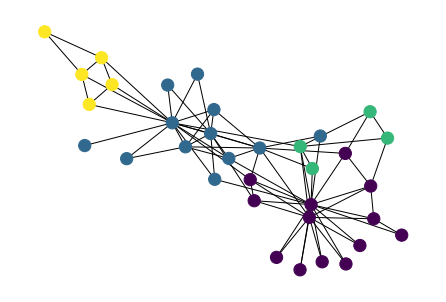

In [9]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y, node_size=150)

## Graph Convolutional Networks


Graph Convolutional Networks (GCNs) will be used to classify nodes in the test set. To give a brief theoretical introduction, a layer in a graph neural network can be written as a non-linear function $f$:

$$h^{(k+1)} = f(h^{(k)}, A),$$

where GCN layer take as inputs the graph’s adjacency matrix $A$ and latent node features $h^{(k)}$ for some layer $k$.

A simple layer-wise propagation rule for a graph neural network would look something like this:

$$f(h^{(k)}, A) = \sigma \left( A h^{(k)} W^k \right) $$

where $W^k$ is a weight matrix for the $k$-th neural network layer, and $\sigma$ is a non-linear activation function. Multiplying the weights with the adjacency matrix means that all the feature vectors of all (1-hop) neighboring nodes are summed and aggregated for every node:

$$ h^{(k+1)_v} = \sigma \left( (A h^{(k)} W^k)_v \right) = \sigma \left( W^{(k)} \sum_{u \in N(v)} \frac{h^{(k)}_u}{|N(v)|} \right). $$

Note that the feature vector of the node itself is not included. Kipf and Welling proposed to add the identity matrix to the adjacency matrix $A$ and denote this new matrix $\hat{A} = A + I$. Multiplication of the adjacency matrix will also change the scale of the feature vectors. To counteract this $\hat{A}$ is multiplied by its diagonal degree matrix symmetrically, yielding the final GCN propagation rule:

$$f(h^{(k)}, A) = \sigma \left( \hat{D}^{-\frac{1}{2}} \hat{A} \hat{D}^{-\frac{1}{2}} h^{(k)} W^k \right), $$

where $\hat{D}$ is the diagonal **node degree** matrix of$\hat{A}$ .



## Construct GCN deep model

Next we prepare the GCN deep model in code. The GCN layer is already a part of what PyG, and it can be readily be imported as the `GCNConv` class.

It is 3-layer GCN:
* The first layer has many input units as the number of features every node has.
* The latent dimension is set to 4
* The last one is set to 2. 

The 2-dimensional latent embedding allows us to plot and see if the model manages to learn embeddings that are similar for nodes belonging to the same class. 

The **hyperbolic tangent** activation function is used in-between GCN layers as a non-linearity.


In [13]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(dataset.num_features, 4)
    self.conv2 = GCNConv(4, 4)
    self.conv3 = GCNConv(4, 2)
    self.classifier = Linear(2, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    h = h.tanh()
    out = self.classifier(h)
    return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


### First Embedding 

In [14]:
out, h = model(data.x, data.edge_index)
print("Embedding shape:", h.shape)

Embedding shape: torch.Size([34, 2])


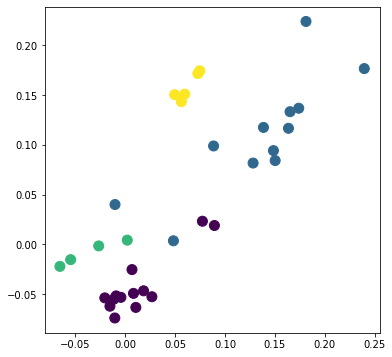

In [15]:
import matplotlib.pyplot as plt

def plot_embedding(h, color=data.y, size=100):
  h = h.detach().numpy()
  fig = plt.figure(figsize=(6, 6))
  plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
  plt.show()

plot_embedding(h)

## Train GCN model

We use **cross-entropy** as loss functions since it is well suited for multi-class classification problems, and initialize **Adam** as a stochastic gradient optimizer. We create a standard PyTorch training loop, and let it run for **300 epochs**.

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
  optimizer.zero_grad()
  out, h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) # the loss is only calculated for nodes in the training set
  loss.backward()
  optimizer.step()
  return loss, h

epochs = range(1, 301)
losses = []
embeddings = []
for epoch in epochs:
  loss, h = train(data)
  losses.append(loss)
  embeddings.append(h)
  print(f"Epoch: {epoch}\tLoss: {loss:.4f}")

Epoch: 1	Loss: 1.3996
Epoch: 2	Loss: 1.3749
Epoch: 3	Loss: 1.3545
Epoch: 4	Loss: 1.3380
Epoch: 5	Loss: 1.3248
Epoch: 6	Loss: 1.3137
Epoch: 7	Loss: 1.3034
Epoch: 8	Loss: 1.2929
Epoch: 9	Loss: 1.2814
Epoch: 10	Loss: 1.2689
Epoch: 11	Loss: 1.2553
Epoch: 12	Loss: 1.2410
Epoch: 13	Loss: 1.2264
Epoch: 14	Loss: 1.2117
Epoch: 15	Loss: 1.1971
Epoch: 16	Loss: 1.1827
Epoch: 17	Loss: 1.1682
Epoch: 18	Loss: 1.1534
Epoch: 19	Loss: 1.1382
Epoch: 20	Loss: 1.1224
Epoch: 21	Loss: 1.1060
Epoch: 22	Loss: 1.0895
Epoch: 23	Loss: 1.0730
Epoch: 24	Loss: 1.0569
Epoch: 25	Loss: 1.0412
Epoch: 26	Loss: 1.0259
Epoch: 27	Loss: 1.0108
Epoch: 28	Loss: 0.9960
Epoch: 29	Loss: 0.9816
Epoch: 30	Loss: 0.9677
Epoch: 31	Loss: 0.9545
Epoch: 32	Loss: 0.9420
Epoch: 33	Loss: 0.9302
Epoch: 34	Loss: 0.9189
Epoch: 35	Loss: 0.9080
Epoch: 36	Loss: 0.8976
Epoch: 37	Loss: 0.8876
Epoch: 38	Loss: 0.8781
Epoch: 39	Loss: 0.8690
Epoch: 40	Loss: 0.8601
Epoch: 41	Loss: 0.8515
Epoch: 42	Loss: 0.8430
Epoch: 43	Loss: 0.8347
Epoch: 44	Loss: 0.82

In [64]:
out, h = model.forward(data.x, data.edge_index)
pred = model.classifier(h)
print(model.classifier(h))
# print(out[data.train_mask])

tensor([[-0.0537,  3.9365, -4.7856, -0.5195],
        [ 0.3152,  3.5771, -4.3836, -0.7413],
        [ 3.8595, -0.2684, -0.1227, -2.7923],
        [ 0.3486,  3.5361, -4.3386, -0.7596],
        [-3.6943, -0.8126, -0.3265,  3.3349],
        [-3.7276, -0.8280, -0.3142,  3.3645],
        [-3.7276, -0.8279, -0.3143,  3.3645],
        [ 0.8453,  2.9716, -3.7155, -1.0419],
        [ 3.9127, -0.3482, -0.0363, -2.8187],
        [ 3.8938, -0.3977,  0.0121, -2.7936],
        [-3.6943, -0.8115, -0.3276,  3.3347],
        [ 0.0120,  3.6706, -4.5090, -0.5185],
        [ 0.1614,  3.6537, -4.4769, -0.6341],
        [ 2.3326,  1.3654, -1.9351, -1.9041],
        [ 3.8987, -0.4349,  0.0503, -2.7901],
        [ 3.8984, -0.4343,  0.0497, -2.7900],
        [-3.7204, -0.8414, -0.2998,  3.3615],
        [ 0.1783,  3.6278, -4.4488, -0.6424],
        [ 3.8964, -0.4384,  0.0537, -2.7876],
        [ 2.1077,  1.5470, -2.1420, -1.7614],
        [ 3.8950, -0.4398,  0.0549, -2.7862],
        [ 0.1976,  3.6006, -4.4193

In [1]:
_, pred = model(data.x, data.edge_index).max(dim=1)
pred

NameError: ignored

In [63]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

The 2 dimensional embeddings from the last GCN layer are stored as a list so that we can animate the evolution of the embeddings during training, giving some insight into the latent space of the model.

In [24]:
embeddings[-1]

tensor([[ 0.9998,  0.9994],
        [ 0.8141,  1.0000],
        [-0.9975,  1.0000],
        [ 0.8380,  1.0000],
        [ 0.9997, -0.9990],
        [ 1.0000, -0.9999],
        [ 1.0000, -0.9999],
        [ 0.4458,  0.9992],
        [-0.9992,  0.9995],
        [-0.9995,  0.9977],
        [ 0.9997, -0.9990],
        [ 0.9593,  0.9924],
        [ 0.9420,  0.9961],
        [-0.5824,  0.9995],
        [-0.9999,  0.9951],
        [-0.9999,  0.9952],
        [ 0.9998, -0.9999],
        [ 0.9085,  0.9951],
        [-0.9999,  0.9950],
        [-0.4196,  0.9968],
        [-0.9999,  0.9950],
        [ 0.9089,  0.9949],
        [-0.9999,  0.9950],
        [-1.0000, -0.7360],
        [-0.9999, -0.9997],
        [-0.9999, -0.9996],
        [-1.0000,  0.9907],
        [-0.9999, -0.8985],
        [-0.9998,  0.8146],
        [-1.0000,  0.9675],
        [-0.9993,  0.9994],
        [-0.9999, -0.7237],
        [-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<TanhBackward0>)

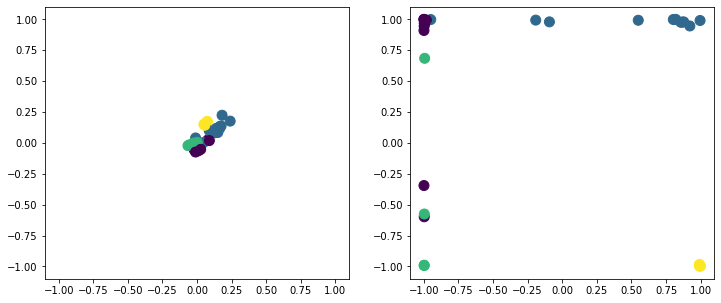

In [22]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

h = embeddings[0]
h = h.detach().numpy()

ax1.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
ax1.set_xlim([-1.1, 1.1])
ax1.set_ylim([-1.1, 1.1])

h = embeddings[-1]
h = h.detach().numpy()

ax2.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
ax2.set_xlim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])

plt.show()


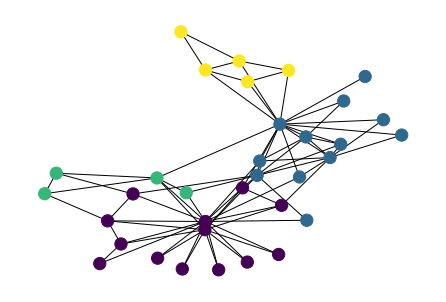

In [31]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y, node_size=150)